In [58]:
# 1. Setup & Imports
import os                               # File system operations
import pandas as pd                     # Data handling
import numpy as np                      # Numerical operations
import matplotlib.pyplot as plt         # Plotting
from matplotlib.collections import LineCollection
import seaborn as sns                   # Advanced visualization
import yfinance as yf                   # Fetch stock data
import pandas_market_calendars as mcal  # Market trading calendar
from datetime import datetime
from scipy import stats                 # Z-score / statistical functions
%matplotlib inline 
import plotly.graph_objects as go
import plotly.express as px

# Display & Plotting settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")
# sns.set_palette("Set2")  # Consistent color theme

# 2. Configuration
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL", "JPM", "TSLA"],  # Tech, Finance, Auto
    "start_date": "2022-01-01",
    "end_date": "2025-01-01",
    "backup_path": "data/backup_stocks.csv",
    "output_long": "data/cleaned_stock_data_long.csv",
    "output_wide": "data/cleaned_stock_data_wide.csv",
}

TICKERS = CONFIG["tickers"]
START_DATE = CONFIG["start_date"]
END_DATE = CONFIG["end_date"]
BACKUP_PATH = CONFIG["backup_path"]

In [59]:
# 3. Data Acquisition
def fetch_stock_data(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Fetch historical stock data from Yahoo Finance with CSV fallback.
    
    Args:
        tickers (list[str]): List of stock tickers (e.g., ['AAPL', 'MSFT']).
        start (str): Start date (YYYY-MM-DD).
        end (str): End date (YYYY-MM-DD).
    
    Returns:
        pd.DataFrame: Multi-ticker data with multi-level columns.
    """
    try:
        if not tickers:
            raise ValueError("No tickers provided")

        data = yf.download(
            tickers, start=start, end=end,
            group_by="ticker", auto_adjust=True, progress=False
        )

        if data.empty:
            raise ValueError("No data fetched; check tickers or dates")

        print(f"✅ Data fetched successfully for {len(tickers)} tickers "
              f"({start} → {end})")
        return data

    except Exception as e:
        print(f"⚠️ yfinance failed: {e}. Loading backup CSV instead...")
        return pd.read_csv(BACKUP_PATH)


raw_data = fetch_stock_data(TICKERS, START_DATE, END_DATE)
raw_data.head()

✅ Data fetched successfully for 5 tickers (2022-01-01 → 2025-01-01)


Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.061378  144.851931  142.728576  143.998322  28646000   
2022-01-04  144.400065  145.481610  142.732080  143.410400  28400000   
2022-01-05  143.430740  143.509694  136.744859  136.831253  54618000   
2022-01-06  136.060093  138.981442  135.623104  136.803955  37348000   
2022-01-07  137.199210  137.500143  134.836508  136.078445  29760000   

Ticker             JPM                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.626389  147.141473  144.309737  146.291046  13120900   
2022-01-04  148.652313  152.515413  148.579935  151.836884  20195800   
2022-01-05  152.737920  153.229384  149.015480  149.060989  17539400   
2022-01-06  151.909718  152.328369  149.142916  150.644638  14047500   
2022-01-07  150.781125  152.473966  150.225945  152.137222  13913300   

Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  325.086220  327.655108  319.686689  324.504578  28865100   
2022-01-04  324.582158  324.940858  316.138745  318.940308  32674300   
2022-01-05  315.886705  316.090299  306.309117  306.696869  40054300   
2022-01-06  303.565678  308.945831  301.956480  304.273346  39646100   
2022-01-07  304.535116  306.813198  300.599379  304.428497  32720000   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  174.345039  179.296076  174.227395  178.443115  104487900   
2022-01-04  179.050994  179.354917  175.609770  176.178406   99310400   
2022-01-05  176.090157  176.639180  171.217554  171.492065   94537600   
2022-01-06  169.315567  171.864620  168.276342  168.629288   96904000   
2022-01-07  169.501866  170.727370  167.678316  168.795975   86709100   

Ticker            TSLA                                                 
Price             Open        High         Low       Close     Volume  
Date                                                                   
2022-01-03  382.583344  400.356659  378.679993  399.926666  103931400  
2022-01-04  396.516663  402.666656  374.350006  383.196655  100248300  
2022-01-05  382.216675  390.113342  360.336670  362.706665   80119800  
2022-01-06  359.000000  362.666656  340.166656  354.899994   90336600  
2022-01-07  360.123322  360.309998  336.666656  342.320007   84164700

In [60]:

# 4. Data Cleaning
def clean_stock_data(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Clean stock data for a single ticker.
    
    Steps:
        - Ensure datetime index and sort by date.
        - Handle missing values (drop if >50%, else ffill/bfill).
        - Drop duplicates and enforce numeric dtypes.
        - Validate constraints (non-negative prices, valid dates).
    
    Args:
        df (pd.DataFrame): Raw data with Date, Open, High, Low, Close, Volume.
        ticker (str): Stock ticker symbol.
    
    Returns:
        pd.DataFrame: Cleaned dataset with 'Ticker' column added.
    """
    df = df.copy()
    df.reset_index(inplace=True)
    df["Ticker"] = ticker

    # Validate inputs
    if df.empty or "Date" not in df:
        raise ValueError(f"❌ No data or missing Date column for {ticker}")
    if (df[["Open", "High", "Low", "Close"]] < 0).any().any():
        raise ValueError(f"❌ Negative prices detected for {ticker}")

    # Ensure datetime and sort
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df.sort_values("Date", inplace=True)

    # Handle missing values (drop if >50% columns missing, else fill)
    missing_pct = df[["Open", "High", "Low", "Close", "Volume"]].isnull().mean(axis=1)
    df = df[missing_pct < 0.5]  # Drop rows with excessive missing values
    df = df.ffill().bfill()  # Forward/backward fill for remaining

    # Drop duplicates
    df.drop_duplicates(subset=["Date"], inplace=True)
    
    # Ensure numeric types
    numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df

# Apply cleaning across tickers
cleaned_list = []
for ticker in TICKERS:
    try:
        temp = raw_data[ticker].reset_index()
        temp = clean_stock_data(temp, ticker)
        cleaned_list.append(temp)
        print(f"✅ {ticker} cleaned successfully ({len(temp)} rows).")
    except Exception as e:
        print(f"⚠️ Error processing {ticker}: {e}")

cleaned_data = pd.concat(cleaned_list, ignore_index=True)

# Drop any stray index column if exists
if "index" in cleaned_data.columns:
    cleaned_data.drop(columns=["index"], inplace=True)

print(f"📊 Final cleaned dataset shape: {cleaned_data.shape}")

✅ AAPL cleaned successfully (753 rows).
✅ MSFT cleaned successfully (753 rows).
✅ GOOGL cleaned successfully (753 rows).
✅ JPM cleaned successfully (753 rows).
✅ TSLA cleaned successfully (753 rows).
📊 Final cleaned dataset shape: (3765, 7)


In [61]:
# 5. Align with Trading Days
def align_with_trading_days(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    """
    Align stock data with official NYSE trading days.
    
    Args:
        df (pd.DataFrame): Cleaned stock data with 'Date' column.
        start (str): Start date.
        end (str): End date.
    
    Returns:
        pd.DataFrame: Data filtered to valid NYSE trading days.
    """
    nyse = mcal.get_calendar("NYSE")
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.normalize()

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df = df[df["Date"].isin(trading_days)]

    print(f"✅ Data aligned with NYSE trading days "
          f"({trading_days.min().date()} → {trading_days.max().date()})")
    return df


cleaned_data = align_with_trading_days(cleaned_data, START_DATE, END_DATE)

✅ Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)


In [62]:
# 6. Outlier Detection
def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect outliers in daily returns using Z-score and IQR.
    
    Adds:
        - Daily_Return
        - Z_Score
        - Outlier_Z
        - Outlier_IQR
    
    Args:
        df (pd.DataFrame): Cleaned stock data with Ticker, Date, Close.
    
    Returns:
        pd.DataFrame: Original data with outlier columns.
    """
    df = df.copy()
    
    # Daily returns
    df["Daily_Return"] = df.groupby("Ticker")["Close"].pct_change()

    # Z-score method
    df["Z_Score"] = df.groupby("Ticker")["Daily_Return"].transform(
        lambda x: stats.zscore(x, nan_policy="omit")
    )
    df["Outlier_Z"] = df["Z_Score"].abs() > 3

    # IQR method
    def iqr_outliers(series):
        q1, q3 = np.nanpercentile(series, [25, 75])
        iqr = q3 - q1
        return (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))

    df["Outlier_IQR"] = df.groupby("Ticker")["Daily_Return"].transform(iqr_outliers)

    print("✅ Outlier detection completed (Z-score & IQR).")
    return df


cleaned_data = detect_outliers(cleaned_data)

✅ Outlier detection completed (Z-score & IQR).


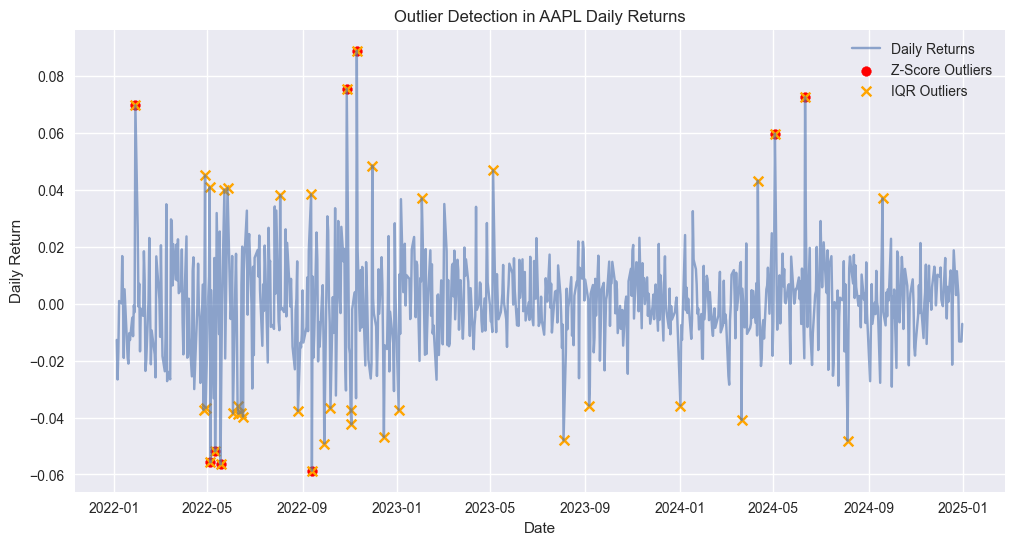

In [63]:
# 7. Outlier Visualization 
def plot_outliers(df: pd.DataFrame, tickers: list[str] | str):
    """
    Plot daily returns and highlight outliers for one or more tickers.

    Args:
        df (pd.DataFrame): Data with 'Date', 'Daily_Return', 'Outlier_Z', 'Outlier_IQR', 'Ticker'.
        tickers (list[str] | str): Single ticker or list of tickers to plot.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        subset = df[df["Ticker"] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Returns", alpha=0.6)
        plt.scatter(subset["Date"][subset["Outlier_Z"]],
                    subset["Daily_Return"][subset["Outlier_Z"]],
                    color="red", label="Z-Score Outliers")
        plt.scatter(subset["Date"][subset["Outlier_IQR"]],
                    subset["Daily_Return"][subset["Outlier_IQR"]],
                    color="orange", marker="x", label="IQR Outliers")

        plt.title(f"Outlier Detection in {ticker} Daily Returns")
        plt.xlabel("Date")
        plt.ylabel("Daily Return")
        plt.legend()
        plt.show()



# Example: Plot for all tickers in a loop
plot_outliers(cleaned_data, ["AAPL"]) 
# plot_outliers(cleaned_data, ["AAPL", "JPM"])  # Tech & Finance examples

In [64]:
# 8. Data Quality Report
def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a data quality report per ticker including:
        - Row count
        - Date range
        - Missing values %
        - Duplicates
        - Outliers %
        - Trading days coverage %

    Args:
        df (pd.DataFrame): Cleaned stock data with Ticker, Date, Close, etc.

    Returns:
        pd.DataFrame: Summary report per ticker.
    """
    core_cols = ["Open", "High", "Low", "Close", "Volume"]
    report = []
    nyse = mcal.get_calendar("NYSE")

    for ticker, group in df.groupby("Ticker"):
        total_rows = len(group)
        missing_pct = (group[core_cols].isnull().sum().sum() / (total_rows * len(core_cols))) * 100
        duplicates = group.duplicated(subset=["Date"]).sum()
        min_date, max_date = group["Date"].min(), group["Date"].max()
        outlier_pct = group["Outlier_Z"].mean() * 100 if "Outlier_Z" in group else np.nan

        # Expected trading days
        schedule = nyse.schedule(start_date=min_date, end_date=max_date)
        expected_days = len(schedule)
        coverage_pct = (total_rows / expected_days) * 100 if expected_days > 0 else np.nan

        report.append({
            "Ticker": ticker,
            "Rows": total_rows,
            "Date Range": f"{min_date.date()} → {max_date.date()}",
            "Missing %": f"{missing_pct:.2f}%",
            "Duplicates": duplicates,
            "Outliers (Z%)": f"{outlier_pct:.2f}%" if not np.isnan(outlier_pct) else "N/A",
            "Trading Days Coverage %": f"{coverage_pct:.2f}%"
        })

    return pd.DataFrame(report)


# Run the report
quality_report = data_quality_report(cleaned_data)
print("📊 Data Quality Report")
display(quality_report)


📊 Data Quality Report


,Ticker,Rows,Date Range,Missing %,Duplicates,Outliers (Z%),Trading Days Coverage %
0,AAPL,753,2022-01-03 → 2024-12-31,0.00%,0,1.20%,100.00%
1,GOOGL,753,2022-01-03 → 2024-12-31,0.00%,0,1.20%,100.00%
2,JPM,753,2022-01-03 → 2024-12-31,0.00%,0,1.33%,100.00%
3,MSFT,753,2022-01-03 → 2024-12-31,0.00%,0,0.93%,100.00%
4,TSLA,753,2022-01-03 → 2024-12-31,0.00%,0,1.20%,100.00%


In [65]:
# 9. Validation Tests
def validate_preprocessing(df: pd.DataFrame):
    """
    Perform automated checks to ensure preprocessing correctness:
        1. No missing core values
        2. Daily returns computed correctly
        3. Non-negative prices
        4. No duplicate dates
        5. Date ranges within bounds
    """
    # 1. Missing values
    assert df[["Open", "High", "Low", "Close", "Volume"]].isnull().sum().sum() == 0, \
        "❌ Missing values remain!"

    # 2. Daily returns consistency
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        expected_returns = subset["Close"].pct_change()
        assert np.allclose(subset["Daily_Return"].dropna(), expected_returns.dropna(), equal_nan=True), \
            f"❌ Daily returns mismatch for {ticker}"

    # 3. Non-negative prices
    assert (df[["Open", "High", "Low", "Close"]] >= 0).all().all(), "❌ Negative prices detected!"

    # 4. No duplicates
    for ticker, group in df.groupby("Ticker"):
        assert not group["Date"].duplicated().any(), f"❌ Duplicates found in {ticker}"

    # 5. Date range validation
    for ticker, group in df.groupby("Ticker"):
        assert group["Date"].min() >= pd.to_datetime(START_DATE), f"❌ Start date invalid for {ticker}"
        assert group["Date"].max() <= pd.to_datetime(END_DATE), f"❌ End date invalid for {ticker}"

    print("✅ Preprocessing validations passed!")


# Run validation
validate_preprocessing(cleaned_data)

✅ Preprocessing validations passed!


In [66]:
# 10. Data Transformation (Wide Format)

# Pivot data to have dates as index and tickers as columns for Close prices
pivot_data = cleaned_data.pivot(index="Date", columns="Ticker", values="Close")
pivot_data = pivot_data.ffill().bfill()  # Ensure no gaps

print(f"Wide-format data shape: {pivot_data.shape}")
pivot_data.head()

Wide-format data shape: (753, 5)


Ticker,AAPL,GOOGL,JPM,MSFT,TSLA
Date,,,,,
2022-01-03,178.443115,143.998322,146.291046,324.504578,399.926666
2022-01-04,176.178406,143.410400,151.836884,318.940308,383.196655
2022-01-05,171.492065,136.831253,149.060989,306.696869,362.706665
2022-01-06,168.629288,136.803955,150.644638,304.273346,354.899994
2022-01-07,168.795975,136.078445,152.137222,304.428497,342.320007


In [67]:
# 11. Basic Statistics & Sector Analysis

# Compute daily returns for each ticker
daily_returns = pivot_data.pct_change()

# Stats per ticker
stats_report = pd.DataFrame({
    "Ticker": daily_returns.columns,
    "Mean Return": daily_returns.mean(),
    "Volatility (Std)": daily_returns.std(),
    "Min Return": daily_returns.min(),
    "Max Return": daily_returns.max(),
    "Skewness": daily_returns.skew(),
    "Kurtosis": daily_returns.kurtosis(),
    "Sharpe Ratio (≈)": daily_returns.mean() / daily_returns.std()
}).reset_index(drop=True)

print("📊 Daily Returns Statistics with Skewness, Kurtosis, Sharpe Ratio")
display(stats_report)

📊 Daily Returns Statistics with Skewness, Kurtosis, Sharpe Ratio


,Ticker,Mean Return,Volatility (Std),Min Return,Max Return,Skewness,Kurtosis,Sharpe Ratio (≈)
0,AAPL,0.000591,0.017067,-0.058680,0.088975,0.213380,2.514827,0.034635
1,GOOGL,0.000572,0.020627,-0.095094,0.102244,0.013493,2.727510,0.027731
2,JPM,0.000759,0.015743,-0.064678,0.115445,0.398058,5.741108,0.048196
3,MSFT,0.000491,0.017372,-0.077156,0.082268,0.009358,1.955805,0.028278
4,TSLA,0.000755,0.038618,-0.123346,0.219190,0.245814,2.193303,0.019547


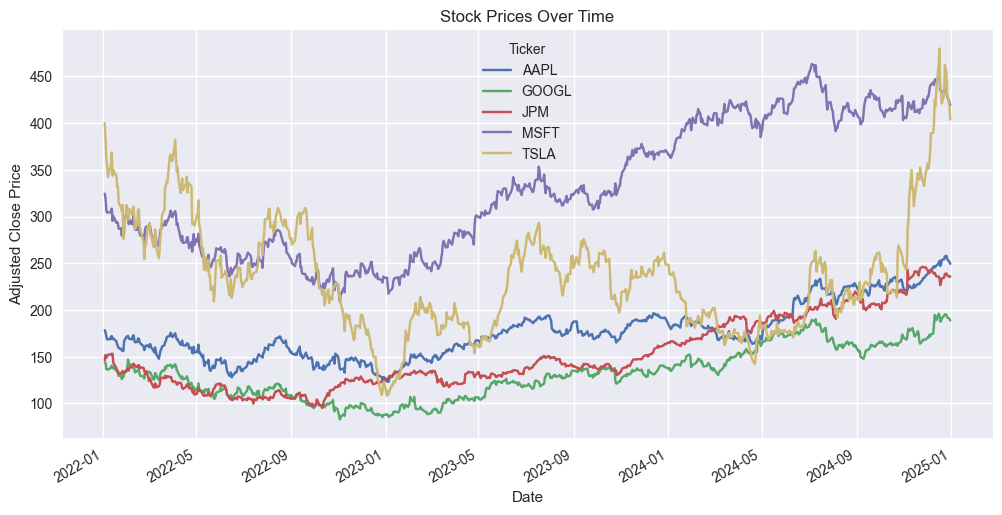

In [68]:
# 12. Enhanced EDA Visualizations

# 12.1 Stock Prices Over Time
pivot_data.plot(figsize=(12,6))
plt.title("Stock Prices Over Time")
plt.ylabel("Adjusted Close Price")
plt.xlabel("Date")
plt.legend(title="Ticker")
plt.show()

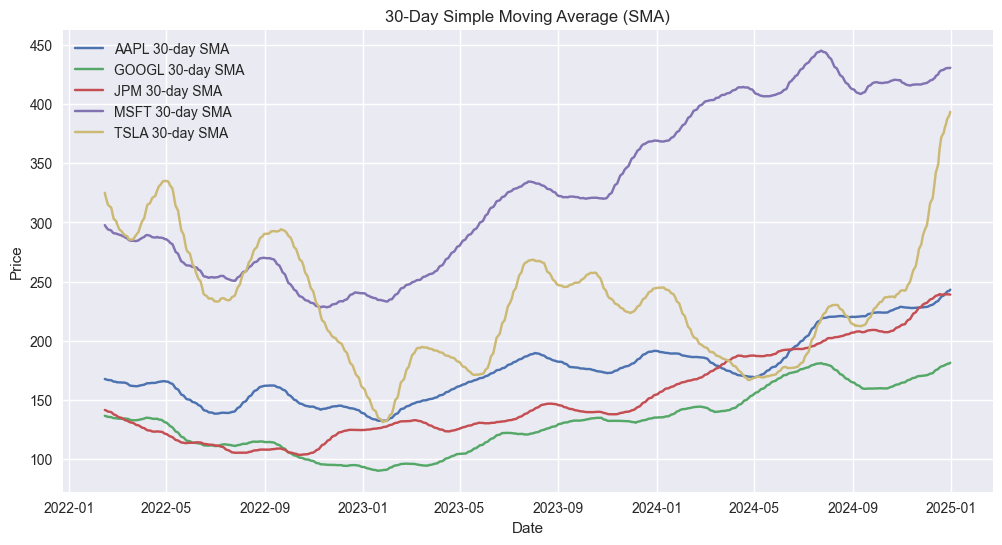

In [69]:
# 12.2 Rolling Statistics (SMA example for all tickers)
rolling_window = 30
plt.figure(figsize=(12,6))
for ticker in pivot_data.columns:
    plt.plot(pivot_data[ticker].rolling(rolling_window).mean(), label=f"{ticker} {rolling_window}-day SMA")
plt.title(f"{rolling_window}-Day Simple Moving Average (SMA)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

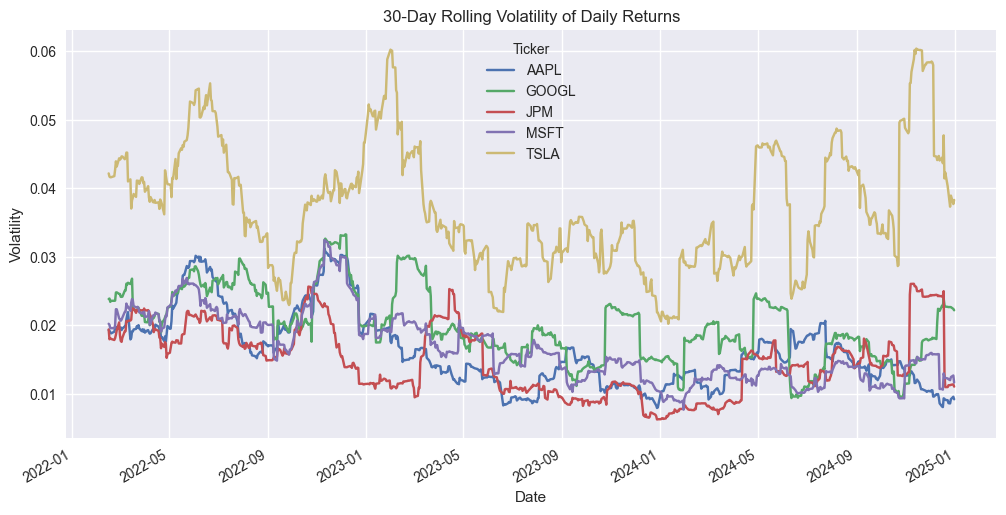

In [70]:
# 12.3 Volatility (Rolling Std Dev of Returns)
rolling_vol = daily_returns.rolling(window=30).std()
rolling_vol.plot(figsize=(12,6))
plt.title("30-Day Rolling Volatility of Daily Returns")
plt.ylabel("Volatility")
plt.show()

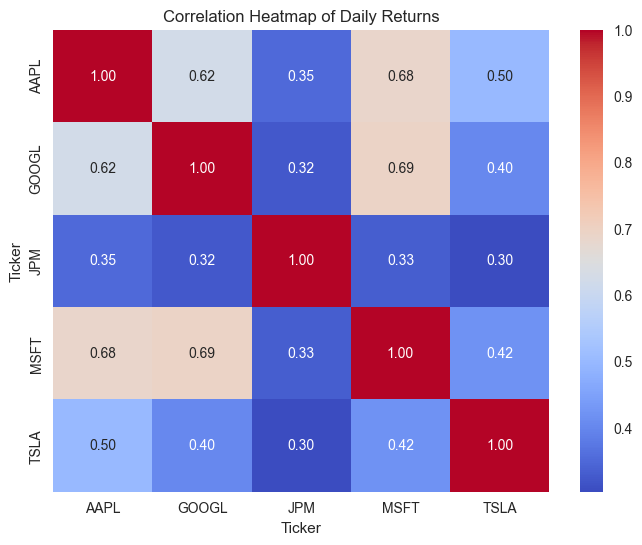

In [71]:
# 12.4 Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Daily Returns")
plt.show()

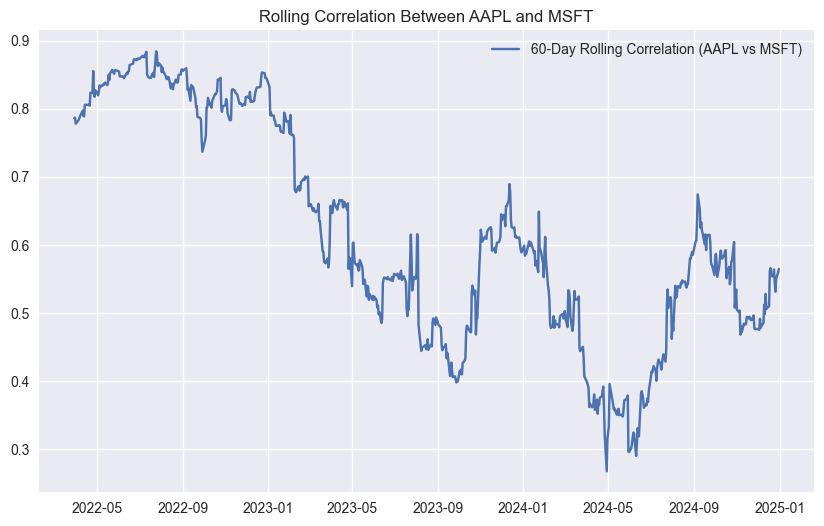

In [72]:
# 12.5 Rolling Correlation Example (AAPL vs MSFT)
rolling_corr = daily_returns["AAPL"].rolling(60).corr(daily_returns["MSFT"])
plt.figure(figsize=(10,6))
plt.plot(rolling_corr, label="60-Day Rolling Correlation (AAPL vs MSFT)")
plt.title("Rolling Correlation Between AAPL and MSFT")
plt.legend()
plt.show()

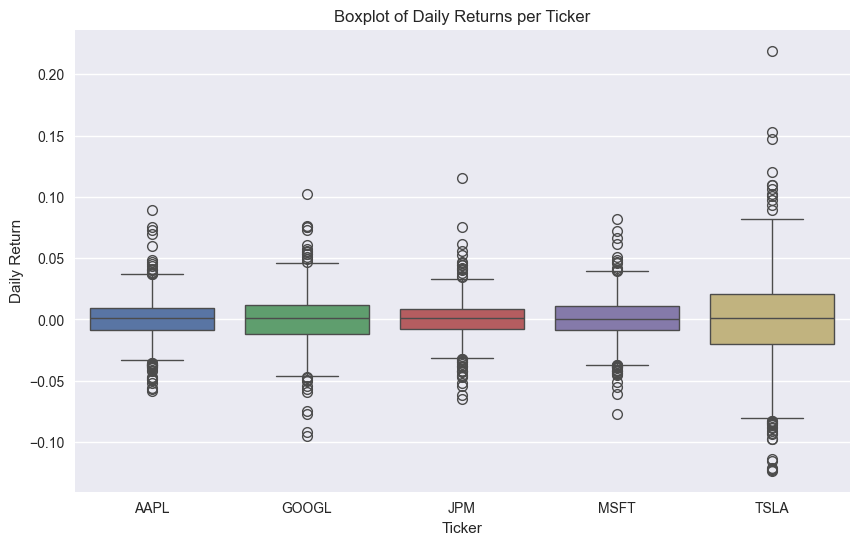

In [73]:
# 12.6 Boxplots per ticker (showing spread & outliers)
plt.figure(figsize=(10,6))
sns.boxplot(data=daily_returns, orient="v")
plt.title("Boxplot of Daily Returns per Ticker")
plt.ylabel("Daily Return")
plt.show()

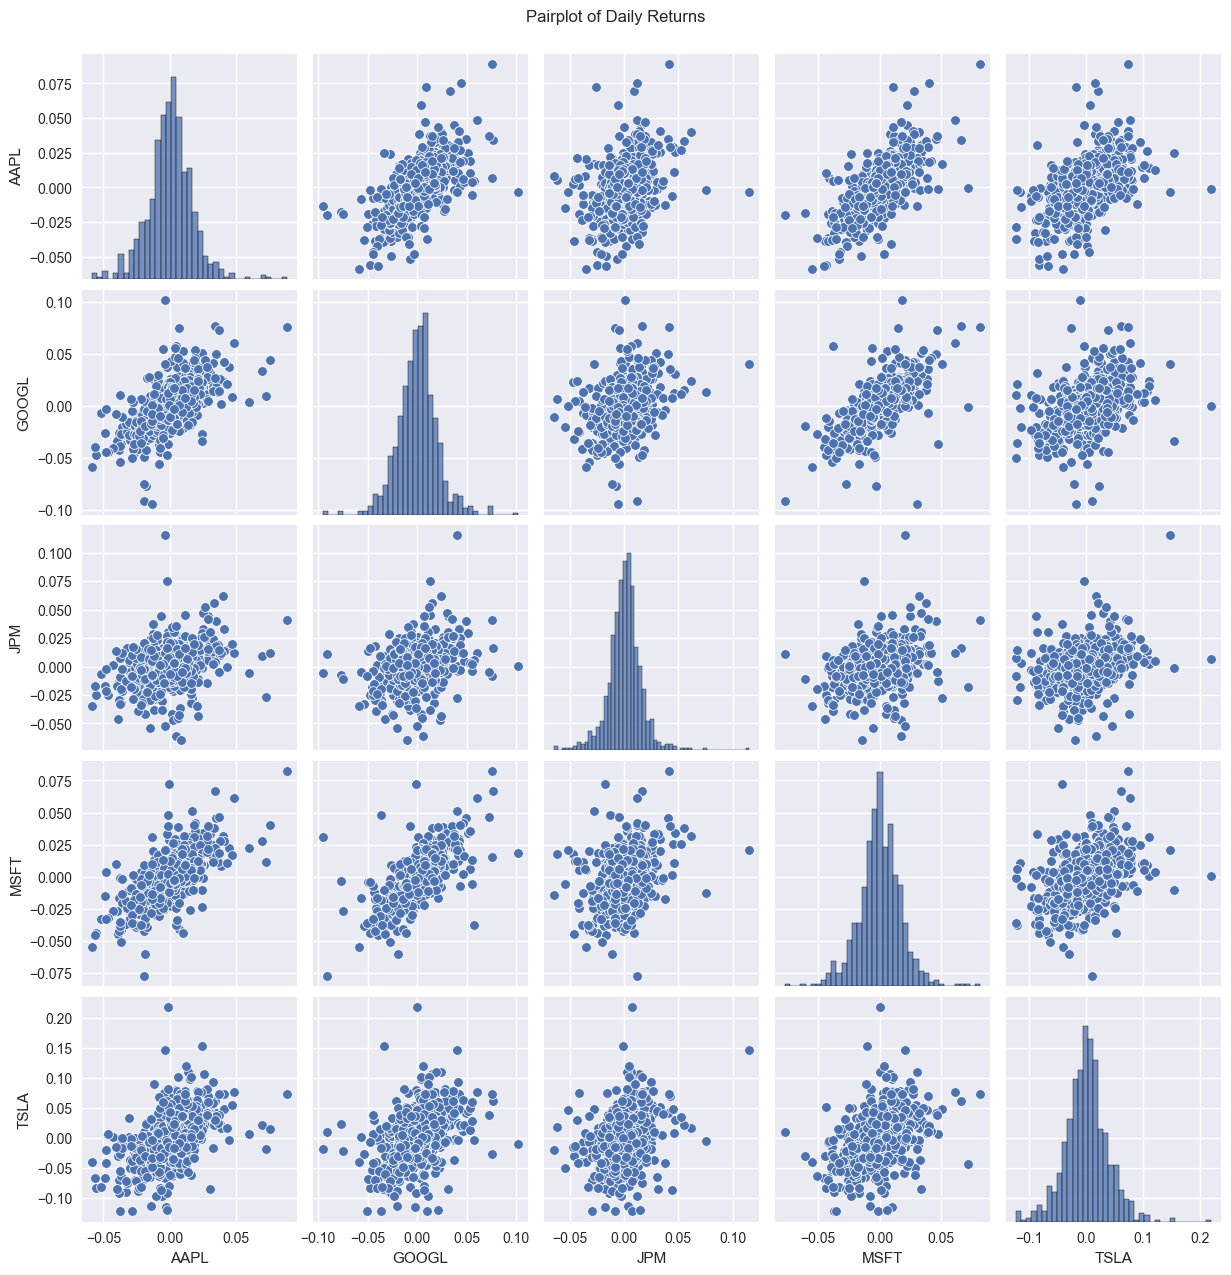

In [74]:
# 12.7 Pairplot of returns for quick visual relationships
sns.pairplot(daily_returns.dropna())
plt.suptitle("Pairplot of Daily Returns", y=1.02)
plt.show()

In [75]:
# 13. Save Cleaned Datasets
# Ensure directories exist
os.makedirs(os.path.dirname(CONFIG["output_long"]), exist_ok=True)
os.makedirs(os.path.dirname(CONFIG["output_wide"]), exist_ok=True)

# 13.1 Save long-format dataset (tidy)
cleaned_data.to_csv(CONFIG["output_long"], index=False)
print(f"✅ Long-format dataset saved: {CONFIG['output_long']}")

# 13.2 Save wide-format dataset (pivot)
pivot_data.to_csv(CONFIG["output_wide"])
print(f"✅ Wide-format dataset saved: {CONFIG['output_wide']}")

✅ Long-format dataset saved: data/cleaned_stock_data_long.csv
✅ Wide-format dataset saved: data/cleaned_stock_data_wide.csv


In [76]:
# function for making a simple moving function for a selected amount of days
df = pd.read_csv('data/cleaned_stock_data_wide.csv')

def find_sma(df, window_no, stock):
    sma = df[stock].rolling(window=window_no).mean()
    return sma



In [77]:
df.head()

,Date,AAPL,GOOGL,JPM,MSFT,TSLA
0,2022-01-03,178.443115,143.998322,146.291046,324.504578,399.926666
1,2022-01-04,176.178406,143.410400,151.836884,318.940308,383.196655
2,2022-01-05,171.492065,136.831253,149.060989,306.696869,362.706665
3,2022-01-06,168.629288,136.803955,150.644638,304.273346,354.899994
4,2022-01-07,168.795975,136.078445,152.137222,304.428497,342.320007


In [78]:
def plot_price_sma_interactive(dates, prices, smas, save_folder="Graphs", filename="price_sma.html"):
    """
    Plot stock closing prices with one or more Simple Moving Averages (SMA) using Plotly.
    Saves the interactive chart as an HTML file.

    Args:
        dates (pd.Series): Dates or index values for the x-axis.
        prices (pd.Series): Closing prices.
        smas (list of pd.Series): One or more SMA series to overlay.
        save_folder (str): Directory to save the HTML chart. Defaults to "Graphs".
        filename (str): Name of the HTML file. Defaults to "price_sma.html".

    Returns:
        None. Displays chart and saves interactive HTML.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig = go.Figure()

    # Closing price
    fig.add_trace(go.Scatter(
        x=dates,
        y=prices,
        mode='lines',
        name='Close Price',
        line=dict(color='green', width=2),
        hovertemplate='Date: %{x}<br>Close: %{y}<extra></extra>'
    ))

    # Add all SMA lines
    for sma in smas:
        fig.add_trace(go.Scatter(
            x=dates,
            y=sma,
            mode='lines',
            name=sma.name,
            line=dict(width=2, dash='dash'),
            hovertemplate='Date: %{x}<br>%{text}: %{y}<extra></extra>',
            text=[sma.name]*len(sma)  # show SMA name on hover
        ))

    # Layout
    fig.update_layout(
        title=dict(text='Stock Prices with SMA Overlay', x=0.5, font=dict(size=22)),
        xaxis_title='Date',
        yaxis_title='Closing Price',
        template='plotly_white',
        width=1200,
        height=600,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            # rangeslider=dict(visible=True),
            type="date",
            showgrid=True,
            gridcolor='lightgrey',
            tickangle=-45
        ),
        yaxis=dict(showgrid=True, gridcolor='lightgrey')
    )

    fig.show()

    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")



In [79]:
def highlight_streaks_interactive_multi(df, dates, price_cols, save_folder="Graphs", filename="highlighted_streaks.html"):
    """
    Highlight upward and downward streaks for multiple stock prices using colored line segments.

    Args:
        df (pd.DataFrame): DataFrame containing the stock data.
        dates (str): Column name in `df` representing dates (must be datetime).
        price_cols (list of str): List of column names representing stock closing prices.

    Behavior:
        - Segments where the price increased are colored green.
        - Segments where the price decreased are colored red.
        - Segments with no change are colored blue.

    Returns:
        None. Displays an interactive Plotly chart and saves as HTML.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig = go.Figure()
    
    for price_col in price_cols:
        df_copy['Change'] = df_copy[price_col].diff().fillna(0)

        for i in range(1, len(df_copy)):
            change = df_copy['Change'].iloc[i]
            color = 'green' if change > 0 else ('red' if change < 0 else 'blue')

            show_text = i == len(df_copy) - 1  # only show text at last point
            fig.add_trace(go.Scatter(
                x=df_copy[dates].iloc[i-1:i+1],
                y=df_copy[price_col].iloc[i-1:i+1],
                mode='lines+text' if show_text else 'lines',
                line=dict(color=color, width=3),
                text=[price_col] if show_text else None,
                textposition="top right",
                showlegend=False,
                hovertemplate='Date: %{x}<br>Close: %{y}<extra></extra>'
            ))

    fig.update_layout(
        title=dict(text="Stock Price Streaks - Green for Up, Red for Down", x = 0.5, font=dict(size=22)),
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_white",
        width=1200,
        height=600,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            # rangeslider=dict(visible=True),
            type="date",
            showgrid=True,
            gridcolor='lightgrey',
            tickangle=-45
        ),
        yaxis=dict(showgrid=True, gridcolor='lightgrey')
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")




In [80]:
def annotate_profits_interactive(df, dates, prices, sma, save_folder="Graphs", filename="buy_sell_signals.html"):
    """
    Annotate buy/sell signals based on a Simple Moving Average (SMA) crossover strategy
    and plot them interactively with Plotly.

    Strategy:
        - Buy signal: when closing price crosses above the SMA.
        - Sell signal: when closing price crosses below the SMA.
        - Ignores repeated buy/sell signals until the opposite action occurs.

    Args:
        df (pd.DataFrame): DataFrame containing stock price and SMA data.
        dates (str): Column name in `df` representing dates.
        prices (str): Column name in `df` representing the closing price series.
        sma (str): Column name in `df` representing the SMA series.
        save_folder (str, optional): Folder path to save the interactive HTML chart.
            Defaults to "Graphs".
        filename (str, optional): Name of the output HTML file. 
            Defaults to "buy_sell_signals.html".

    Returns:
        None. Displays an interactive Plotly chart and saves it as an HTML file.

    Side Effects:
        - Adds two new columns to `df`: `Buy` and `Sell`, containing NaN except
          at buy/sell points where the closing price is stored.
        - Creates `save_folder` if it does not already exist.
        - Saves the interactive chart to the specified HTML file.

    """

    # Ensure folder exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    buy_signals = []
    sell_signals = []
    flag = -1  # -1: no position, 1: holding, 0: sold

    for i in range(len(df)):
        # Buy signal: Close crosses above SMA
        if df[prices].iloc[i] > df[sma].iloc[i]:
            if flag != 1:  # only buy if not already holding
                buy_signals.append(df[prices].iloc[i])
                sell_signals.append(np.nan)
                flag = 1
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)

        # Sell signal: Close crosses below SMA
        elif df[prices].iloc[i] < df[sma].iloc[i]:
            if flag != 0:  # only sell if holding
                buy_signals.append(np.nan)
                sell_signals.append(df[prices].iloc[i])
                flag = 0
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    fig = go.Figure()

    # Plot Close Price
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[prices],
        mode='lines',
        name='Close Price',
        line=dict(color='blue', width=2),
        hovertemplate=(
            "<b>Close Price</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot SMA line
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[sma],
        mode='lines',
        name=sma,
        line=dict(color='orange', width=2, dash='dash'),
        hovertemplate=(
            "<b>Date</b>: %{x}<br>" +
            f"<b>{sma}</b>: " + "%{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot Buy signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Buy'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='triangle-up', color='green', size=12),
        hovertemplate=(
            "<b>Buy Signal</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot Sell signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Sell'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='triangle-down', color='red', size=12),
        hovertemplate=(
            "<b>Sell Signal</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Layout
    fig.update_layout(
        title=dict(text="Stock Buy/Sell Signals Based on SMA Strategy", x = 0.5, font=dict(size=22)),
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_white",
        width=1300,
        height=600,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            # rangeslider=dict(visible=True),
            type="date",
            showgrid=True,
            gridcolor='lightgrey',
            tickangle=-45
        ),
        yaxis=dict(showgrid=True, gridcolor='lightgrey')
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")
    

In [81]:
def plot_annual_risk_return_interactive(df, save_folder="Graphs", filename="annual_risk_return.html"):
    """
    Calculate annual risk (volatility) and annual return for each stock column in df
    and plot an interactive scatter plot with Plotly. Saves the chart as an HTML file.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices with 'Date' column.
        save_folder (str): Folder to save the HTML file.
        filename (str): Name of the HTML file.S
    """
    returns = df.drop(columns=["Date"]).pct_change().dropna()

    summary = pd.DataFrame({
        "Annual Return": returns.mean() * 252,    # average daily return * trading days
        "Annual Risk": returns.std() * (252 ** 0.5)  # daily std * sqrt(trading days)
    })

    summary.reset_index(inplace=True)
    summary.rename(columns={"index": "Stock"}, inplace=True)

    # Add Sharpe Ratio for better insight
    summary["Sharpe Ratio"] = summary["Annual Return"] / summary["Annual Risk"]

    fig = px.scatter(
        summary,
        x="Annual Risk",
        y="Annual Return",
        text="Stock",
        size="Sharpe Ratio",   # bubble size indicates Sharpe Ratio
        color="Stock",
        hover_data=["Sharpe Ratio"],
        title="Annual Risk vs Return"
    )

    fig.update_traces(textposition="top center")
    fig.update_layout(
        width=900, 
        height=600,
        title=dict(text="Annual Risk vs Return",x=0.5, font=dict(size=22))
    )

    # Create folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Save HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")

    # Show chart
    fig.show()


In [82]:
def sma_input(df):
    """
    Prompt user to select a stock and one or more SMA windows, calculate SMA(s),
    and plot the stock with SMA overlays interactively without modifying the original DataFrame.
    User can type 'exit' to quit at any prompt.

    Args:
        df (pd.DataFrame): Original DataFrame containing stock prices with 'Date' column.

    Returns:
        None. Only plots the SMAs; original df is unchanged.
    """

    # Make a temporary copy
    temp_df = df.copy()

    allowed_columns = ['AAPL', 'GOOGL', 'JPM', 'MSFT', 'TSLA']
    stock_columns = [col for col in allowed_columns if col in temp_df.columns]

    # --- Select stock ---
    while True:
        stock_col = input(f"Enter one of the stock column ({', '.join(stock_columns)}) or type 'exit' to quit: ").strip()
        if stock_col.lower() == 'exit':
            print("Exiting...")
            return
        if stock_col not in stock_columns:
            print("Invalid column name. Please choose a valid stock column.")
            continue
        break

    # --- Enter SMA windows ---
    while True:
        input_sma_str = input("Enter SMA window(s) separated by commas (e.g., 5,20,50) or type 'exit' to quit: ").strip()
        if input_sma_str.lower() == 'exit':
            print("Exiting...")
            return
        try:
            sma_windows = [int(x.strip()) for x in input_sma_str.split(",")]

            # Validate each SMA
            valid_smas = []
            for w in sma_windows:
                if w <= 0:
                    print(f"SMA window {w} must be positive.")
                elif w > len(temp_df):
                    print(f"SMA window {w} cannot be larger than dataset length ({len(temp_df)}).")
                else:
                    valid_smas.append(w)

            if not valid_smas:
                print("No valid SMA windows entered. Try again.")
                continue

            break
        except ValueError:
            print("Invalid input. Please enter numeric values separated by commas.")

    # --- Calculate SMA(s) ---
    sma_series_list = []
    for w in valid_smas:
        sma_col_name = f"SMA_{stock_col}_{w}"
        temp_df[sma_col_name] = find_sma(df, w, stock_col)
        
        # Ensure the Series has a name
        sma_series = temp_df[sma_col_name]
        sma_series.name = sma_col_name
        sma_series_list.append(sma_series)

    # --- Plot interactively ---
    plot_price_sma_interactive(temp_df['Date'], temp_df[stock_col], sma_series_list)

    print("Plot generated.")



In [83]:
def highlight_streaks_input(df):
    """
    Prompt the user to select one or more stock columns to highlight streaks interactively.
    User can type 'exit' to quit at any prompt.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices with a 'Date' column.

    Returns:
        None. Generates and displays the interactive chart.
    """
    allowed_columns = ['AAPL', 'GOOGL', 'JPM', 'MSFT', 'TSLA']
    available_columns = [col for col in allowed_columns if col in df.columns]

    while True:
        user_input = input(
            f"Enter stock columns to highlight (comma separated) from {', '.join(available_columns)} "
            "or type 'exit' to quit: "
        ).strip()

        if user_input.lower() == 'exit':
            print("Exiting...")
            return  # exit function

        selected_columns = [col.strip() for col in user_input.split(",")]

        # Validate input
        invalid_cols = [col for col in selected_columns if col not in available_columns]
        if invalid_cols:
            print(f"Invalid columns: {', '.join(invalid_cols)}. Please try again.")
            continue
        if not selected_columns:
            print("No valid columns entered. Please try again.")
            continue

        break

    # Call the interactive streak-highlighting function
    highlight_streaks_interactive_multi(df, 'Date', selected_columns)




In [84]:
def annotate_profits_input(df):
    """
    Prompt user to select one stock and one SMA window, calculate SMA, 
    and plot buy/sell signals based on that SMA.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices with a 'Date' column.
    
    Returns:
        None. Displays the plot interactively.
    """

    # Make a temporary copy
    temp_df = df.copy()

    allowed_columns = ['AAPL', 'GOOGL', 'JPM', 'MSFT', 'TSLA']
    available_columns = [col for col in allowed_columns if col in df.columns]

    # --- Select one stock ---
    while True:
        stock_col = input(f"Enter a stock column ({', '.join(available_columns)}) or type 'exit' to quit: ").strip()
        if stock_col.lower() == 'exit':
            print("Exiting...")
            return  # exit the function
        if stock_col not in available_columns:
            print("Invalid column name. Please choose a valid stock column.")
            continue
        break

    # --- Enter one SMA window ---
    while True:
        try:
            input_str = input("Enter a SMA window (e.g. 5) or type 'exit' to quit: ").strip()
            if input_str.lower() == 'exit':
                print("Exiting...")
                return  # exit the function
            window_no = int(input_str)
            if window_no <= 0:
                print("SMA window must be positive.")
            elif window_no > len(df):
                print(f"SMA window cannot be larger than dataset length ({len(df)}).")
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")


    # --- Calculate SMA ---
    sma_series = find_sma(df, window_no, stock_col)
    sma_name = f"SMA_{stock_col}_{window_no}"
    temp_df[sma_name] = sma_series

    # --- Plot buy/sell signals ---
    annotate_profits_interactive(temp_df, 'Date', stock_col, sma_name)


In [ ]:
def interactive_plot_menu(df):
    """
    Interactive menu for plotting stock data.
    User can choose among:
      1. SMA overlay plot
      2. Highlight streaks plot
      3. Annotate buy/sell signals plot
    Loops until the user types 'exit'.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices with 'Date' column.

    Returns:
        None. Generates plots interactively based on user choice.
    """
    menu_options = {
        "1": "SMA overlay plot",
        "2": "Highlight streaks plot",
        "3": "Annotate buy/sell signals plot",
        "4": "Annual Risk Return",
        "exit": "Exit the program"
    }

    while True:
        print("\nSelect an option:")
        for key, desc in menu_options.items():
            print(f"  {key}: {desc}")

        choice = input("Enter your choice (or 'exit' to quit): ").strip().lower()

        if choice == "exit":
            print("Exiting...")
            break
        elif choice == "1":
            print("\n--- SMA Overlay Plot ---")
            sma_input(df)
        elif choice == "2":
            print("\n--- Highlight Streaks Plot ---")
            highlight_streaks_input(df)
        elif choice == "3":
            print("\n--- Annotate Buy/Sell Signals Plot ---")
            annotate_profits_input(df)
        elif choice == "4":
            print("\n--- Annual Risk Return ---")
            plot_annual_risk_return_interactive(df)
        else:
            print("Invalid choice. Please select a valid option.")

# Run the interactive menu
interactive_plot_menu(df)

